In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:

file = pd.read_csv('../data/Inplaydata19.csv', error_bad_lines=False)
dataFrame = pd.DataFrame(file)



In [7]:
# Single, Double, Triple, HomeRun, (field_out, force_out, fielders_choice) = out, 
# grounded_into_double_play, sac_fly, sac_bunt,

#Transform values into binary classification
d = {
    'single': 1, 
    'double': 1, 
    'triple': 1, 
    'home_run': 1, 
    'field_out': 0,
    'force_out': 0,
    'fielders_choice': 1,
    'grounded_into_double_play': 0,
    'sac_fly': 0,
    'sac_bunt': 0,
    'double_play': 0,
    'fielders_choice_out': 0,
    'catcher_interf': 1,
    'triple_play': 0,
    'field_error': 1,
    'sac_fly_double_play': 0,
    'sac_bunt_double_play': 0
}

dataFrame = dataFrame.replace(d)


In [8]:
X = pd.DataFrame()
X['launch_speed'] = dataFrame['launch_speed']
X['launch_angle'] = dataFrame['launch_angle']
X['launch_speed_angle'] = dataFrame['launch_speed_angle']
X['estimated_ba_using_speedangle'] = dataFrame['estimated_ba_using_speedangle']
X['hc_x']=125-dataFrame['hc_x']
X['hc_y']=198-dataFrame['hc_y']
X['events'] = dataFrame['events']
X.insert(0, 'Ones', 1)
X=X[X['hc_y']!=0]
X = X.dropna()

y = X['events']

X = X.iloc[:, 0:-1]


In [9]:


X['hor_rad']=np.arctan(X['hc_x']/X['hc_y'])
X['hor_deg']=X['hor_rad']*(180/np.pi)

In [16]:
meanspd=np.mean(X['launch_speed'])
stdspd=np.std(X['launch_speed'])
meanang=np.mean(X['launch_angle'])
stdang=np.std(X['launch_angle'])
stdhor=np.std(X['hor_rad'])


In [18]:
normX=pd.DataFrame()
normX['launch_speed']=(X['launch_speed']-meanspd)/stdspd
normX['launch_angle']=(X['launch_angle']-meanang)/stdang
normX['hor_angle']=(X['hor_rad'])/stdhor

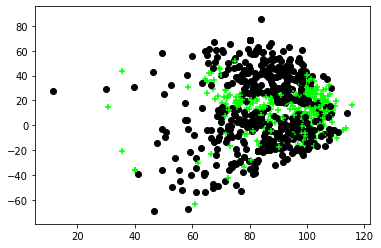

In [10]:
plt.figure()
color = [[0,0,0]]
for i in range(800):
    if y[i] == 0:
        marker="o"
        color = [[0,0,0]]
    elif y[i] == 1:
        marker="+"
        color = [[0,1,0]]
    plt.scatter(X.loc[i, 'launch_speed'], X.loc[i, 'launch_angle'], c=color, marker=marker) 
    
plt.show()


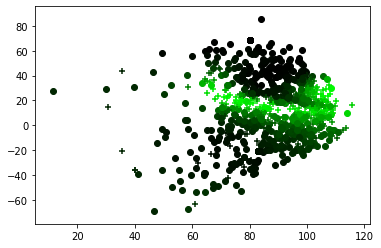

In [11]:
plt.figure()
color = [[0,0,0]]
for i in range(800):
    if y[i] == 0:
        marker="o"
        #color = [[0,0,0]]
    elif y[i] == 1:
        marker="+"
        #color = [[0,1,0]]
    
    colored= X['estimated_ba_using_speedangle'][i]
    color=[[0,colored,0]]
    plt.scatter(X.loc[i, 'launch_speed'], X.loc[i, 'launch_angle'], c=color, marker=marker) 
    
plt.show()

In [22]:
#Trim data
sliceX = normX.iloc[0:10000]
slicey = y.iloc[0:10000]

In [12]:


C = 10
rbf_svc = svm.SVC(kernel='rbf', C=C, gamma='auto')
scoresRBF = cross_val_score(rbf_svc, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scoresRBF))

ValueError: Found input variables with inconsistent numbers of samples: [999, 1000]

In [ ]:
hyperparams = { 
    'C': np.linspace(1, 100, 100),
    'gamma': np.linspace(0.00, 5, 100),
    'class_weight': ['balanced', None],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

rs = RandomizedSearchCV(svm.SVC(), hyperparams, cv=10, n_iter=25, verbose=2, scoring='accuracy')
rs.fit(sliceX, slicey)
print(rs.best_params_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0, total= 1.5min
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0, total=  49.2s
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0 
[CV]  kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0, total= 1.5min
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0 
[CV]  kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0, total=  42.4s
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0 
[CV]  kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0, total= 1.9min
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0 
[CV]  kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0, total=  42.3s
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0 
[CV]  kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0, total= 1.2min
[CV] kernel=linear, gamma=4.090909090909091, class_weight=balanced, C=68.0

In [ ]:
rbf_svc = svm.SVC(kernel='rbf', C=68, gamma=0.55, class_weight='balanced')
scoresRBF = cross_val_score(rbf_svc, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scoresRBF))

In [6]:
rf = RandomForestClassifier(n_estimators=20,n_jobs=-1,random_state=42)
scores_rf = cross_val_score(rf, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scores_rf))

0.802011601160116


In [23]:
rf_hyperparams = { 
    'n_estimators': np.arange(100, 1000, 10),
    'max_features': ['auto', 'sqrt'],
    'max_depth': np.arange(10,100,10),
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap':[True,False]
    
}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, rf_hyperparams, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(sliceX, slicey)
print(rf_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.0min finished


{'n_estimators': 650, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


In [25]:
rf = RandomForestClassifier(n_estimators=650, min_samples_split=2,min_samples_leaf=4,max_depth=40,bootstrap=True,n_jobs=-1,random_state=42)
scores_rf = cross_val_score(rf, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scores_rf))

0.8197987667987668
